In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

### Configurações para os experimentos

In [2]:
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_PRE_CROP_WIDTH = 240
IMAGE_PRE_CROP_HEIGHT = 240
ROTATION_ANGLE = 45
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Utilitário para exibir alguns exemplos do dataset

In [3]:
def tuple2dict(image, label):
    sample_dict = {
        'image': image,
        'label': label
    }
    return sample_dict

In [4]:
def show_examples(dataset, info):
    dataset = dataset.map(tuple2dict, num_parallel_calls=AUTOTUNE)
    tfds.show_examples(dataset, info, rows=2, cols=4)
    plt.close()

### Carregando o dataset rock_paper_scissors

In [5]:
(jokempo_train, jokempo_test), info = tfds.load('rock_paper_scissors',
                                                split=['train', 'test'],
                                                shuffle_files=True,
                                                as_supervised=True,
                                                with_info=True)

In [6]:
print(info)

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)



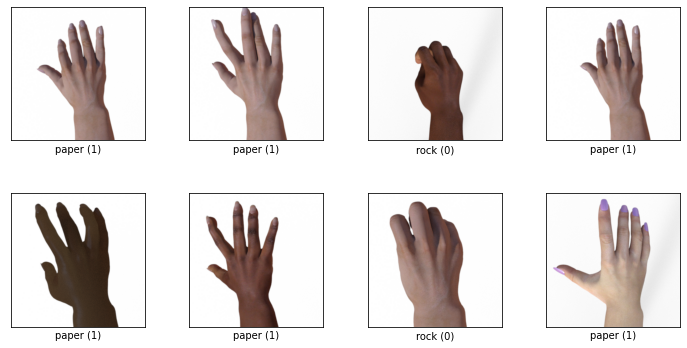

In [7]:
show_examples(jokempo_train, info)

### Preparando o pipeline para o treinamento

In [8]:
TRAIN_LENGHT = info.splits['train'].num_examples
TEST_LENGHT = info.splits['test'].num_examples
NUM_CLASSES = info.features['label'].num_classes

In [9]:
def deg2rad(deg):
    pi_on_180 = 0.017453292519943295
    return deg * pi_on_180

In [10]:
def resize_image(image, label):
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
    
    return image, label

In [11]:
def read_decode_image(image, label):
    image = tf.cast(image, tf.float32) / 255.
    
    return image, label

In [12]:
def apply_augmentation(image, label):
    rotation_theta = deg2rad(ROTATION_ANGLE)
    
    image = tf.image.resize(image, [IMAGE_PRE_CROP_WIDTH, IMAGE_PRE_CROP_HEIGHT])
    image = tf.image.random_flip_left_right(image)
    image = tfa.image.rotate(image,
                             tf.random.uniform(shape=[1], minval=-rotation_theta, maxval=rotation_theta),
                             interpolation='BILINEAR')
    image = tf.image.random_crop(image, size=[IMAGE_WIDTH, IMAGE_HEIGHT, 3])
    
    return image, label

In [13]:
jokempo_train = jokempo_train.map(read_decode_image, num_parallel_calls=AUTOTUNE)
jokempo_train = jokempo_train.map(apply_augmentation, num_parallel_calls=AUTOTUNE)

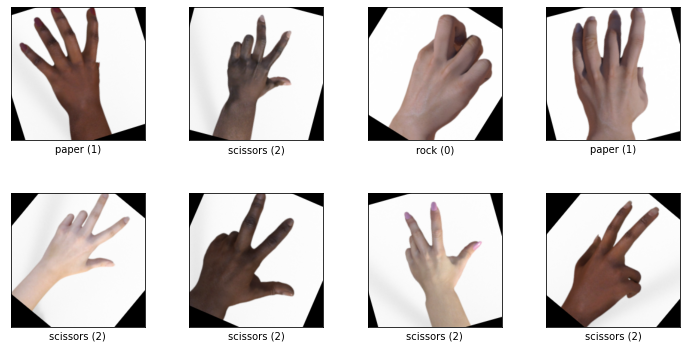

In [14]:
show_examples(jokempo_train, info)

Preparação do dataset para treinamento:

In [15]:
jokempo_train = jokempo_train.repeat(EPOCHS)
jokempo_train = jokempo_train.shuffle(buffer_size=TRAIN_LENGHT)
jokempo_train = jokempo_train.batch(BATCH_SIZE, drop_remainder=True)
jokempo_train = jokempo_train.prefetch(buffer_size=AUTOTUNE)

Preparação do conjunto de teste:

In [16]:
jokempo_test = jokempo_test.map(read_decode_image, num_parallel_calls=AUTOTUNE)
jokempo_test = jokempo_test.map(resize_image, num_parallel_calls=AUTOTUNE)
jokempo_test = jokempo_test.repeat(EPOCHS)
jokempo_test = jokempo_test.batch(BATCH_SIZE, drop_remainder=True)
jokempo_test = jokempo_test.prefetch(buffer_size=AUTOTUNE)

### Preparando o modelo com TensorflowHub

In [17]:
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'
feature_extractor = hub.KerasLayer(MODEL_URL,
                                   input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3),
                                   trainable=False)

In [18]:
model = Sequential([
  feature_extractor,
  Dense(NUM_CLASSES)
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Treinamento do modelo

In [21]:
history = model.fit(jokempo_train,
                    steps_per_epoch=TRAIN_LENGHT // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=jokempo_test,
                    validation_steps=TEST_LENGHT // BATCH_SIZE,
                    initial_epoch=0)

Train for 78 steps, validate for 11 steps
Epoch 1/10
78/78 [==============================] - 10s 134ms/step - loss: 0.4306 - accuracy: 0.8598 - val_loss: 0.2708 - val_accuracy: 0.9403
Epoch 2/10
78/78 [==============================] - 4s 49ms/step - loss: 0.1066 - accuracy: 0.9872 - val_loss: 0.3014 - val_accuracy: 0.9119
Epoch 3/10
78/78 [==============================] - 4s 51ms/step - loss: 0.0642 - accuracy: 0.9912 - val_loss: 0.2601 - val_accuracy: 0.9233
Epoch 4/10
78/78 [==============================] - 4s 51ms/step - loss: 0.0515 - accuracy: 0.9952 - val_loss: 0.2212 - val_accuracy: 0.9318
Epoch 5/10
78/78 [==============================] - 3s 44ms/step - loss: 0.0378 - accuracy: 0.9948 - val_loss: 0.2078 - val_accuracy: 0.9460
Epoch 6/10
78/78 [==============================] - 4s 49ms/step - loss: 0.0279 - accuracy: 0.9980 - val_loss: 0.2242 - val_accuracy: 0.9148
Epoch 7/10
78/78 [==============================] - 4s 50ms/step - loss: 0.0220 - accuracy: 0.9988 - val_loss:

### Resultados

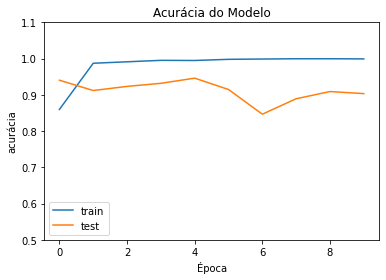

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.1])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

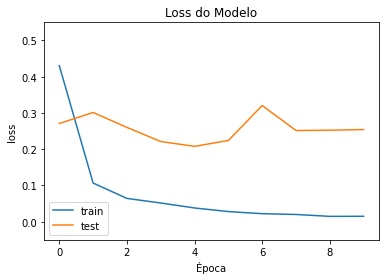

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([-0.05, 0.55])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='lower left')
plt.show()